<a href="https://colab.research.google.com/github/MarciaFG/scimobility/blob/main/FOR11_source_target_dynamics_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FOR 11
## Medical and Health Sciences

**Dataset description:**\
`researcher_idx:` a unique index for each researcher pair\
`researcher_id:` a unique identifier for each researcher\
`time1 and time2:` the two time periods being compared\
`cosine_similarity:` the cosine similarity between the research profiles of the two researchers in the pair\
`angular_similarity_deg:` the angular similarity (in degrees) between the research profiles of the two researchers in the pair\
`source_grid, target_grid, and grid_id:` identifiers for the researchers' organizations\
`organization_name and t_organization_name_target:` the names of the source and target organizations for the researchers in the pair\
`p_fractional:` fractional count of publications for the source institution\
`tcs:` total citation score for the source institution\
`mcs:` mean citation score for the source institution\
`tncs:` total normalized citation score for the source institution\
`mncs:` mean normalized citation score for the source institution\
`p_top_10_prop:` proportion of publications in the top 1% for the source institution\
`pp_top_10_prop:` proportion of top 1% publications per researcher for the source institution\
`t_p_fractional_target:` fractional count of publications for the target institution\
`t_tcs_target:` total citation score for the target institution\
`t_mcs_target:` mean citation score for the target institution\
`t_tncs_target:` total normalized citation score for the target institution\
`t_mncs_target:` mean normalized citation score for the target institution\
`t_p_top_10_prop_target:` proportion of publications in the top 1% for the target institution\
`t_pp_top_10_prop_target:` proportion of top 1% publications per researcher for the target institution

In [1]:
#@title Install drivers
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
#!pip install psutil
#!pip install humanize
#!pip install pynput
#pip install plotly==5.4.0
!pip install patool

# main libraries
import psutil
import humanize
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import requests
import torch
import nltk
import GPUtil as GPU
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity
from scipy import stats

# plotting
import plotly.graph_objs as go
import plotly.io as pio
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

# Google big query
from google.cloud import bigquery
from google.colab import files
%load_ext google.colab.data_table
%load_ext google.cloud.bigquery

# mount drive
from google.colab import drive
drive.mount('/content/drive')

/bin/bash: nvidia-smi: command not found
Your runtime has 13.6 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime → "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#@title Load data
similarity_df = pd.read_csv('/content/drive/MyDrive/TRANSFORMATION/similarity_df_six_plus_merged_for11.csv')
ranks_df = pd.read_csv('/content/drive/MyDrive/TRANSFORMATION/grid_ranks_for11.csv')

print(similarity_df.head())
print(ranks_df.head())

   researcher_idx      researcher_id  time1  time2  cosine_similarity  \
0             0.0  ur.01000000010.53      1      2           0.201650   
1             1.0  ur.01000000145.32      1      2           0.139686   
2             1.0  ur.01000000145.32      1      2           0.139686   
3             1.0  ur.01000000145.32      2      3           0.000000   
4             1.0  ur.01000000145.32      2      3           0.000000   

   angular_similarity_deg    source_grid    target_grid  
0               78.366547  grid.461843.c  grid.506261.6  
1               81.970320  grid.410711.2  grid.33199.31  
2               81.970320  grid.410711.2  grid.412839.5  
3               90.000000  grid.33199.31  grid.419897.a  
4               90.000000  grid.412839.5  grid.419897.a  
         grid_id               organization_name  for_division_id  \
0    grid.1001.0  Australian National University             11.0   
1    grid.1002.3               Monash University             11.0   
2  gri

In [3]:
#@title Preprocessing 
# make the dataset more maneagable by filtering out all sources and grids which are not at the top 1000 organisations ranked by PPtop1%
df_target = similarity_df.merge(ranks_df, left_on='target_grid', right_on='grid_id', how='inner')
df_source = similarity_df.merge(ranks_df, left_on='source_grid', right_on='grid_id', how='inner')
#df_target.head()
#print(df_source.head())

# Merge dataset2 to dataset1 based on source_grid
merged_data_source = similarity_df.merge(ranks_df, left_on='source_grid', right_on='grid_id', suffixes=('', '_source'))

# Merge dataset2 to dataset1 based on target_grid
merged_data_target = merged_data_source.merge(ranks_df, left_on='target_grid', right_on='grid_id', suffixes=('', '_target'))

merged_data_target.reset_index(drop=True, inplace=True)

# Rename the columns
merged_data_target.columns = [f't_{col}' if col.endswith('_target') else col for col in merged_data_target.columns]

# Save and read the resulting dataset to/from a CSV file
merged_data_target.to_csv('/content/drive/MyDrive/TRANSFORMATION/for11_combined.csv', index=False, encoding="utf-8")
df = pd.read_csv('/content/drive/MyDrive/TRANSFORMATION/for11_combined.csv')
#print(df.columns)
#print(df.head())

In [ ]:
print(df.columns)

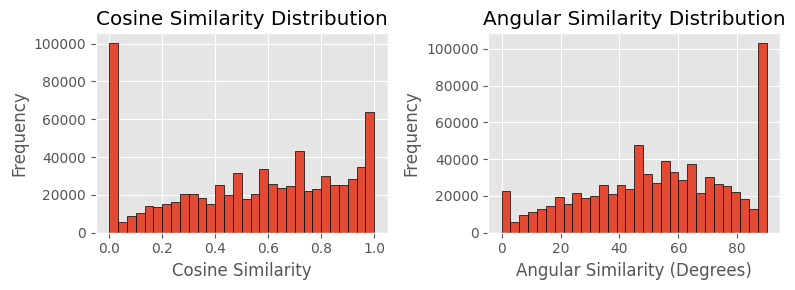

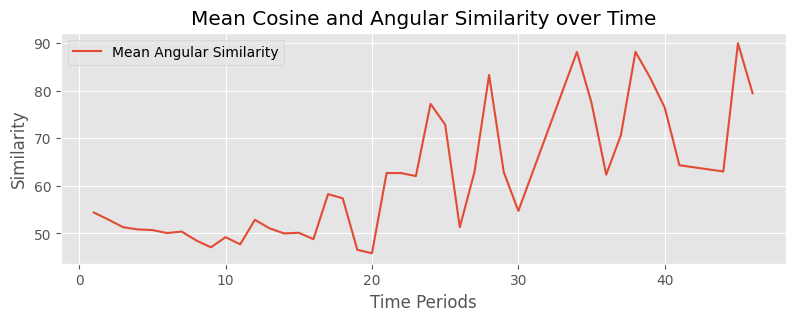

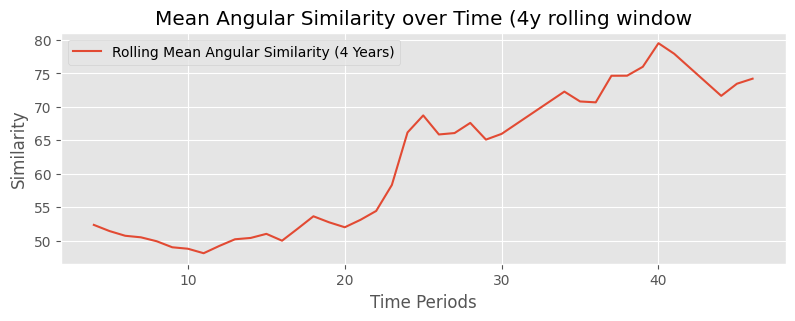

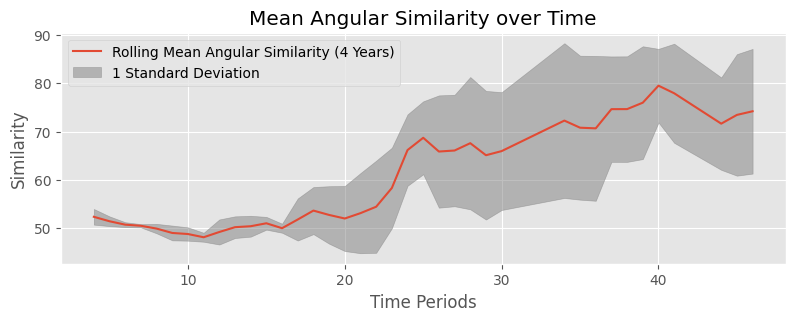

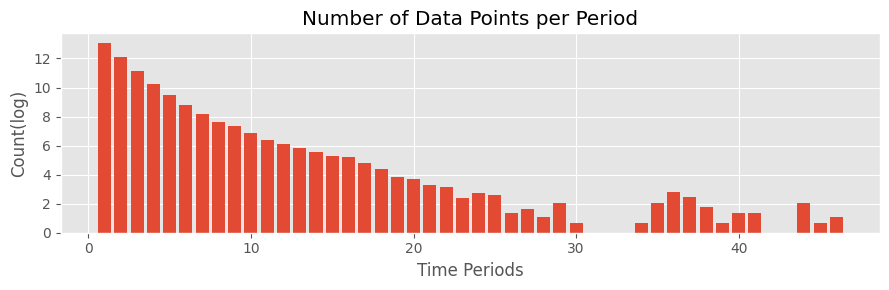

In [6]:
#@title Individual dynamics - overview
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 3))

plt.subplot(1, 2, 1)
plt.hist(df['cosine_similarity'], bins=30, edgecolor='black')
plt.title('Cosine Similarity Distribution')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(df['angular_similarity_deg'], bins=30, edgecolor='black')
plt.title('Angular Similarity Distribution')
plt.xlabel('Angular Similarity (Degrees)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# series
mean_angular_similarity_deg = df.groupby(['time1', 'time2'])['angular_similarity_deg'].mean().reset_index()

plt.figure(figsize=(9.35, 3))

plt.plot(mean_angular_similarity_deg['time1'], mean_angular_similarity_deg['angular_similarity_deg'], label='Mean Angular Similarity')

plt.title('Mean Cosine and Angular Similarity over Time')
plt.xlabel('Time Periods')
plt.ylabel('Similarity')
plt.legend()
plt.show()

# series with rolling window

mean_angular_similarity_deg = df.groupby(['time1', 'time2'])['angular_similarity_deg'].mean().reset_index()

# Calculate mean angular similarity for each year
mean_angular_similarity_deg['year'] = (mean_angular_similarity_deg['time1'] + mean_angular_similarity_deg['time2']) // 2

# Calculate the rolling mean with a window of 4 years
mean_angular_similarity_deg['rolling_mean_angular_similarity'] = mean_angular_similarity_deg['angular_similarity_deg'].rolling(window=4).mean()

plt.figure(figsize=(9.35, 3))

plt.plot(mean_angular_similarity_deg['year'], mean_angular_similarity_deg['rolling_mean_angular_similarity'], label='Rolling Mean Angular Similarity (4 Years)')

plt.title('Mean Angular Similarity over Time (4y rolling window')
plt.xlabel('Time Periods')
plt.ylabel('Similarity')
plt.legend()
plt.show()

# Calculate the rolling standard deviation with a window of 4 years
mean_angular_similarity_deg['rolling_std_angular_similarity'] = mean_angular_similarity_deg['angular_similarity_deg'].rolling(window=4).std()

plt.figure(figsize=(9.35, 3))

plt.plot(mean_angular_similarity_deg['year'], mean_angular_similarity_deg['rolling_mean_angular_similarity'], label='Rolling Mean Angular Similarity (4 Years)')

# Add the shadowing for the standard deviation
plt.fill_between(mean_angular_similarity_deg['year'],
                 mean_angular_similarity_deg['rolling_mean_angular_similarity'] - mean_angular_similarity_deg['rolling_std_angular_similarity'],
                 mean_angular_similarity_deg['rolling_mean_angular_similarity'] + mean_angular_similarity_deg['rolling_std_angular_similarity'],
                 color='gray', alpha=0.5, label='1 Standard Deviation')

plt.title('Mean Angular Similarity over Time')
plt.xlabel('Time Periods')
plt.ylabel('Similarity')
plt.legend()
plt.show()

# Plot the number of data points for each period as a bar chart

data_points_count = df.groupby(['time1', 'time2']).size().reset_index(name='count')

# Calculate the count for each year
data_points_count['year'] = (data_points_count['time1'] + data_points_count['time2']) // 2

plt.figure(figsize=(9, 3))
plt.bar(data_points_count['year'], np.log(data_points_count['count']))
plt.title('Number of Data Points per Period')
plt.xlabel('Time Periods')
plt.ylabel('Count(log)')


plt.tight_layout()
plt.show()

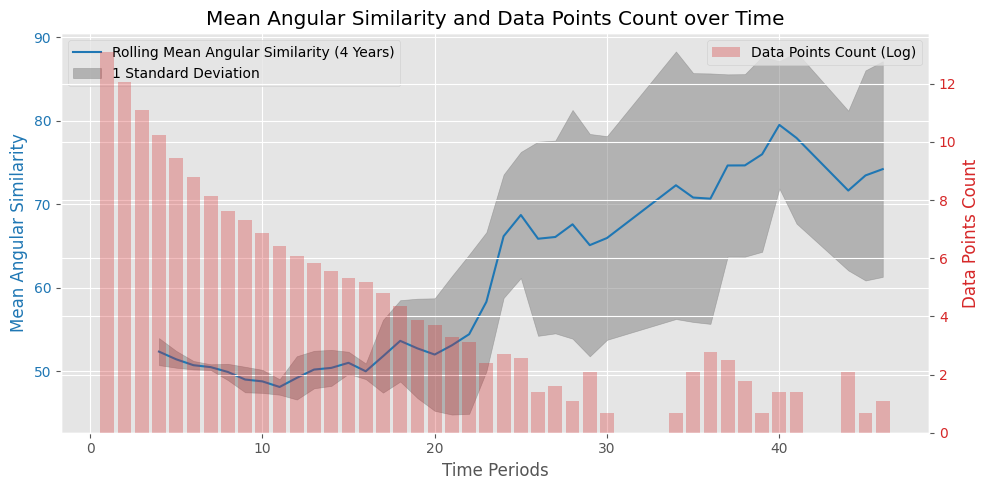

In [7]:
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot the rolling mean angular similarity with standard deviation shadowing
color = 'tab:blue'
ax1.set_title('Mean Angular Similarity and Data Points Count over Time')
ax1.set_xlabel('Time Periods')
ax1.set_ylabel('Mean Angular Similarity', color=color)
ax1.plot(mean_angular_similarity_deg['year'], mean_angular_similarity_deg['rolling_mean_angular_similarity'], color=color, label='Rolling Mean Angular Similarity (4 Years)')
ax1.fill_between(mean_angular_similarity_deg['year'],
                 mean_angular_similarity_deg['rolling_mean_angular_similarity'] - mean_angular_similarity_deg['rolling_std_angular_similarity'],
                 mean_angular_similarity_deg['rolling_mean_angular_similarity'] + mean_angular_similarity_deg['rolling_std_angular_similarity'],
                 color='gray', alpha=0.5, label='1 Standard Deviation')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

# Create a second y-axis to plot the number of data points for each period
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Data Points Count', color=color)
ax2.bar(data_points_count['year'], np.log(data_points_count['count']), color=color, alpha=0.3, label='Data Points Count (Log)')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [46]:
df['performance_ratio'] = df['t_mncs_target'] / df['mncs']
df[['organization_name', 'mncs','t_organization_name_target','t_mncs_target', 'performance_ratio']].head(100)

,organization_name,mncs,t_organization_name_target,t_mncs_target,performance_ratio
0,Institute of Hematology & Blood Diseases Hospital,0.825957,Chinese Academy of Medical Sciences & Peking U...,0.986457,1.194320
1,Institute of Hematology & Blood Diseases Hospital,0.825957,Chinese Academy of Medical Sciences & Peking U...,0.986457,1.194320
2,Institute of Hematology & Blood Diseases Hospital,0.825957,Chinese Academy of Medical Sciences & Peking U...,0.986457,1.194320
3,Institute of Hematology & Blood Diseases Hospital,0.825957,Chinese Academy of Medical Sciences & Peking U...,0.986457,1.194320
4,Institute of Hematology & Blood Diseases Hospital,0.825957,Chinese Academy of Medical Sciences & Peking U...,0.986457,1.194320
...,...,...,...,...,...
95,Huazhong University of Science and Technology,1.145371,Chinese Academy of Medical Sciences & Peking U...,0.986457,0.861255
96,Huazhong University of Science and Technology,1.145371,Chinese Academy of Medical Sciences & Peking U...,0.986457,0.861255
97,Huazhong University of Science and Technology,1.145371,Chinese Academy of Medical Sciences & Peking U...,0.986457,0.861255
98,Huazhong University of Science and Technology,1.145371,Chinese Academy of Medical Sciences & Peking U...,0.986457,0.861255


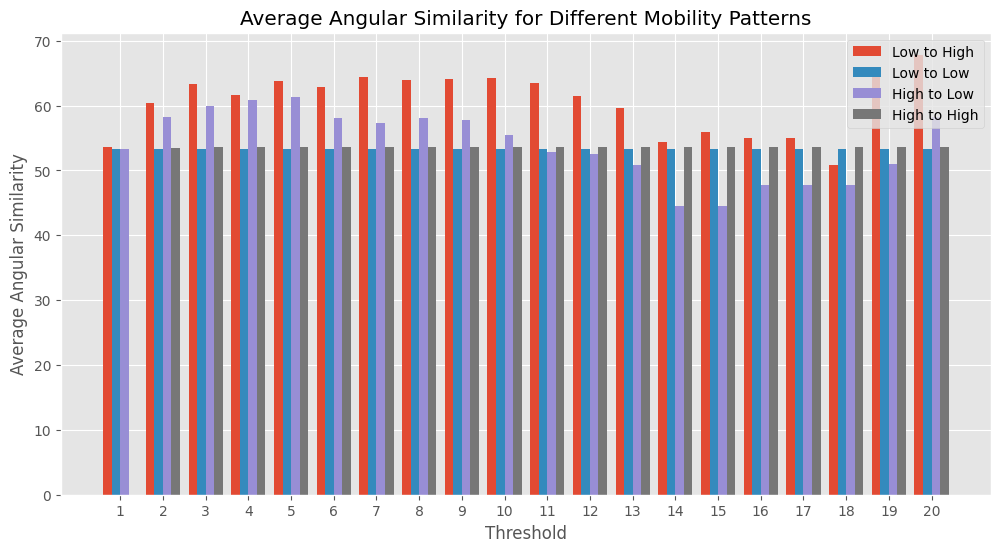

In [50]:
#@title The role of prestige
import numpy as np
import matplotlib.pyplot as plt

def calculate_avg_ang_sim(threshold):
    low_to_high = df[df['performance_ratio'] >= threshold]
    low_to_low = df[(df['performance_ratio'] >= 0.0) & (df['performance_ratio'] < 1)]
    high_to_low = df[df['performance_ratio'] <= 1/threshold]
    high_to_high = df[(df['performance_ratio'] >= 1.0) & (df['performance_ratio'] <= threshold)]

    avg_ang_sim_low_to_high = low_to_high['angular_similarity_deg'].mean()
    avg_ang_sim_low_to_low = low_to_low['angular_similarity_deg'].mean()
    avg_ang_sim_high_to_low = high_to_low['angular_similarity_deg'].mean()
    avg_ang_sim_high_to_high = high_to_high['angular_similarity_deg'].mean()

    return avg_ang_sim_low_to_high, avg_ang_sim_low_to_low, avg_ang_sim_high_to_low, avg_ang_sim_high_to_high

thresholds = np.arange(1, 21)
avg_ang_sim_values = np.array([calculate_avg_ang_sim(threshold) for threshold in thresholds])

plt.figure(figsize=(12, 6))
plt.bar(thresholds - 0.3, avg_ang_sim_values[:, 0], width=0.2, label='Low to High')
plt.bar(thresholds - 0.1, avg_ang_sim_values[:, 1], width=0.2, label='Low to Low')
plt.bar(thresholds + 0.1, avg_ang_sim_values[:, 2], width=0.2, label='High to Low')
plt.bar(thresholds + 0.3, avg_ang_sim_values[:, 3], width=0.2, label='High to High')

plt.xlabel('Threshold')
plt.ylabel('Average Angular Similarity')
plt.title('Average Angular Similarity for Different Mobility Patterns')
plt.xticks(thresholds)
plt.legend()
plt.show()

**It seems the transformation increases with the changing to higher ranked institution as compared to a previous lower ranked institution**

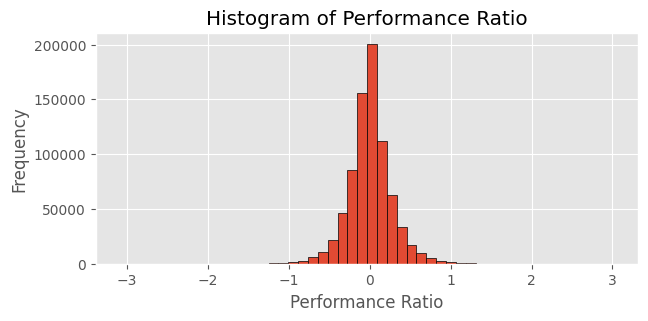

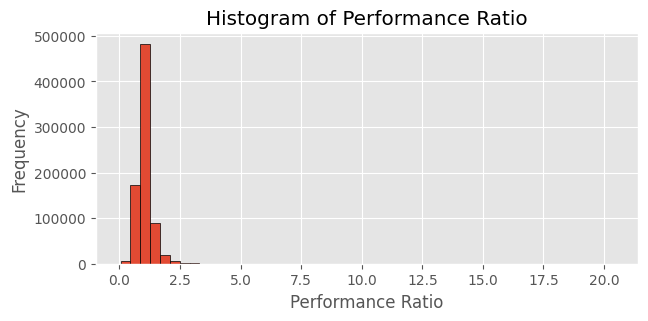

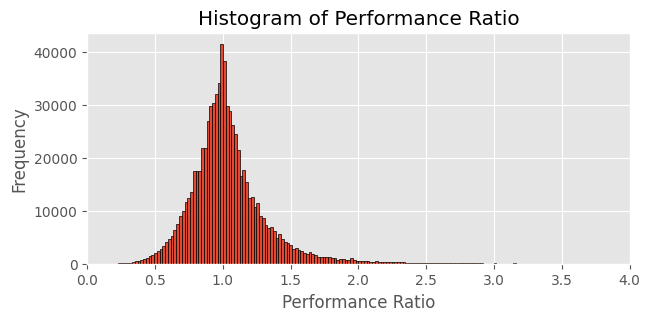

In [48]:
# Plot a histogram for the performance_ratio
plt.figure(figsize=(7, 3))
plt.hist(np.log(df['performance_ratio']), bins=50, edgecolor='black')
plt.xlabel('Performance Ratio')
plt.ylabel('Frequency')
plt.title('Histogram of Performance Ratio')
plt.show()

plt.figure(figsize=(7, 3))
plt.hist(df['performance_ratio'], bins=50, edgecolor='black')
plt.xlabel('Performance Ratio')
plt.ylabel('Frequency')
plt.title('Histogram of Performance Ratio')
plt.show()

plt.figure(figsize=(7, 3))
plt.hist(df['performance_ratio'], bins=1000, edgecolor='black')
plt.xlabel('Performance Ratio')
plt.ylabel('Frequency')
plt.title('Histogram of Performance Ratio')
plt.xlim(0, 4)  # Set the x-axis limits
plt.show()

**For the most part researchers tend to move between comparable ranks**\
**Moving to an institution of a much higher rank from a lower rank is a rare activity**